# longyearbyen_test

In [1]:
%load_ext autoreload
%autoreload 2
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)
#import oogeso
from oogeso.io import file_io
import oogeso.plots as plots
from oogeso.utils import create_time_series_data
import oogeso.dto
import matplotlib.pyplot as plt
import IPython.display
#import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import pickle
import plotly.express as px
import pyomo.environ as pyo
from dataclasses import asdict

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('INFO') #INFO
#print("Using Oogeso version {}".format(oogeso.__version__))


## Read input data

In [2]:
first = pd.read_csv('../tests/test_data/LYR_load.csv')
second = pd.read_csv('../tests/test_data/cap_factors_1hr_airport.csv')
third = pd.read_csv('../tests/test_data/LYR_solar_supply.csv')

merged = pd.merge(first, second, how='left', on='timestamp')
merged = pd.merge(merged, third, how='left', on='timestamp')
merged.fillna(0,inplace=True)
#merged.to_csv('../tests/test_data/profiles_merged.csv', index=False)

In [3]:
merged

timestamp  el_load  heat_load       V25       V47    TUGE50  \
0      2017-01-01 00:00:00     4.81   7.466778  0.000000  0.000000  0.000000   
1      2017-01-01 01:00:00     4.33   7.551868  0.399499  0.556632  0.677735   
2      2017-01-01 02:00:00     4.54   7.573140  0.399499  0.556632  0.677735   
3      2017-01-01 03:00:00     4.69   7.573140  0.307258  0.445659  0.612891   
4      2017-01-01 04:00:00     4.30   7.573140  0.293578  0.427252  0.602084   
...                    ...      ...        ...       ...       ...       ...   
17515  2018-12-31 19:00:00     5.26  10.139872  0.000000  0.000000  0.000000   
17516  2018-12-31 20:00:00     5.16   9.826704  0.000000  0.000000  0.000000   
17517  2018-12-31 21:00:00     5.12   9.640496  0.000000  0.000000  0.000000   
17518  2018-12-31 22:00:00     4.99   9.513536  0.000000  0.000000  0.000000   
17519  2018-12-31 23:00:00     4.93   9.462752  0.000000  0.000000  0.000000   

         TUGE10       MPR           local_time   PV  
0      0.000000  0.000000  2017-01-01 01:00:00  0.0  
1      0.782709  0.470756  2017-01-01 02:00:00  0.0  
2      0.782709  0.470756  2017-01-01 03:00:00  0.0  
3      0.685810  0.360826  2017-01-01 04:00:00  0.0  
4      0.669441  0.343439  2017-01-01 05:00:00  0.0  
...         ...       ...                  ...  ...  
17515  0.000000  0.000000  2018-12-31 20:00:00  0.0  
17516  0.000000  0.000000  2018-12-31 21:00:00  0.0  
17517  0.000000  0.000000  2018-12-31 22:00:00  0.0  
17518  0.000000  0.000000  2018-12-31 23:00:00  0.0  
17519  0.000000  0.000000  2019-01-01 00:00:00  0.0  

[17520 rows x 10 columns]

In [4]:
#case='base' # base case without wind
#case='A' # case with 24 MW wind capacity
#case='B' # case with 24 MW wind capacity AND 4 MW, 4 MWh battery
#case="_base_test"
case="_ir_offshore_pv"
case="_ir_offshore_pv_diesel"
case="_br_offshore_pv_diesel"
#case="all"
#timerange=[0,12*24*7] #one week (with 5 min timestep)
timerange=[0,24*365] #one year (with 1 hour timestep)
timerange=[0,24*7] #one week (with 1 hour timestep)
#timerange=[24*7*100,24*7*104] #four weeks (with 1 hour timestep)
#timerange=[0,4]
#timerange=[1030,1050] #no wind period

outpath = "result/"
plots.plotter="plotly"

data = file_io.read_data_from_yaml('../tests/test_data/longyearbyen_test_2.yaml')

incl_battery=0
incl_hydrogen=0
incl_diesel=0

if case=="_ir_offshore_pv":
    # Combine profiles
    first = pd.read_csv('../tests/test_data/LYR_load.csv')
    second = pd.read_csv('../tests/test_data/cap_factors_1hr_ir.csv')
    third = pd.read_csv('../tests/test_data/LYR_solar_supply.csv')
    merged = pd.merge(first, second, how='left', on='timestamp')
    merged = pd.merge(merged, third, how='left', on='timestamp')
    merged.to_csv('../tests/test_data/profiles'+case+'.csv', index=False)
    wind_P_max=3.45*5 # MW, 5 Vestas V105 turbines
    wind_profile="V105" # Offshore wind profile name with Isfjord Radio data
    pv_P_max=25 # MWp, Sun on all roofs
    incl_hydrogen=1
    incl_battery=1
    data.parameters.co2_tax=1000
    #prof_h2target=oogeso.dto.oogeso_input_data_objects.TimeSeriesData(id="h2target",data=[0.5]*len(data.profiles[0].data))
    #data.profiles.append(prof_h2target)

elif case=="_ir_offshore_pv_diesel":
    # Combine profiles
    first = pd.read_csv('../tests/test_data/LYR_load.csv')
    second = pd.read_csv('../tests/test_data/cap_factors_1hr_ir.csv')
    third = pd.read_csv('../tests/test_data/LYR_solar_supply.csv')
    merged = pd.merge(first, second, how='left', on='timestamp')
    merged = pd.merge(merged, third, how='left', on='timestamp')
    merged.to_csv('../tests/test_data/profiles'+case+'.csv', index=False)
    wind_P_max=3.45*5 # MW, 5 Vestas V105 turbines
    wind_profile="V105" # Offshore wind profile name with Isfjord Radio data
    pv_P_max=25 # MWp, Sun on all roofs
    incl_hydrogen=1
    incl_battery=1
    incl_diesel=1
    data.parameters.co2_tax=1000

elif case=="_br_offshore_pv_diesel":
    # Combine profiles
    first = pd.read_csv('../tests/test_data/LYR_load.csv')
    second = pd.read_csv('../tests/test_data/cap_factors_1hr_br.csv')
    third = pd.read_csv('../tests/test_data/LYR_solar_supply.csv')
    merged = pd.merge(first, second, how='left', on='timestamp')
    merged = pd.merge(merged, third, how='left', on='timestamp')
    merged.to_csv('../tests/test_data/profiles'+case+'.csv', index=False)
    wind_P_max=3.45*3 # MW, 3 Vestas V105 turbines
    wind_profile="V105" # wind profile name with Breinosa data
    pv_P_max=25 # MWp, Sun on all roofs
    incl_hydrogen=0
    incl_battery=1
    incl_diesel=1
    data.parameters.co2_tax=1000

# Create profiles
timeseries = file_io.read_profiles_from_csv(
    filename_forecasts="../tests/test_data/profiles"+case+".csv",
    dayfirst = False)
profiles = create_time_series_data(
    df_forecast=timeseries["forecast"],
    df_nowcast=timeseries["forecast"],
    time_start=None,time_end=None,
    timestep_minutes=60,
    resample_method="linear")
data.profiles = profiles

#data['paramParameters']['planning_horizon']=12

if case=="base_test":
    wind_P_max=0.66*8 # Some turbines
    pv_P_max=25 # MWp Sun on all roofs
    incl_hydrogen=1
    incl_battery=1
    data.parameters.co2_tax=1000
    #prof_h2target=oogeso.dto.oogeso_input_data_objects.TimeSeriesData(id="h2target",data=[0.5]*len(data.profiles[0].data))
    #data.profiles.append(prof_h2target)
elif case=="all":
    # CASE for illustration (to make plots for paper)
    wind_P_max=8*12 # Large wind farm Pmax=2x demand
    incl_battery=1
    incl_hydrogen=1
    data.parameters.co2_tax=1000
    prof_h2target=oogeso.dto.oogeso_input_data_objects.TimeSeriesData(id="h2target",data=[0.5]*len(data.profiles[0].data))
    data.profiles.append(prof_h2target)


hydrogendevices = ['electrolyser','fuelcell','h2_storage']
dieseldevices = ['diesel_source','backup_east_1','backup_east_2','backup_east_3','backup_west_1','backup_west_2','backup_west_3','diesel_boiler_1','diesel_boiler_2','boiler_houses']
for dev in data.devices:
    if dev.id == "wind":
        dev.flow_max = wind_P_max
        dev.profile = wind_profile
    if dev.id == "pv":
        dev.flow_max = pv_P_max
    if dev.id == "el_storage":
        dev.include = incl_battery
    if dev.id in hydrogendevices:
        dev.include = incl_hydrogen
    if dev.id in dieseldevices:
        dev.include = incl_diesel

simulator = oogeso.Simulator(data)

In [5]:
for dev in data.devices:
    if dev.id=='el_load':
        print(dev)

id='el_load' node_id='load' name='general el load' include=True profile='el_load' flow_min=1.0 flow_max=1.0 max_ramp_down=None max_ramp_up=None start_stop=None reserve_factor=0.0 op_cost=None penalty_function=None model=<ModelType.SINK_EL: 'sinkel'>


In [6]:
# Test solve:
simulator.optimiser.solve(solver="gurobi")

{'Problem': [{'Name': 'x124098', 'Lower bound': 0.014833333333333292, 'Upper bound': 0.0148333333333333, 'Number of objectives': 1, 'Number of constraints': 33337, 'Number of variables': 28801, 'Number of binary variables': 8160, 'Number of integer variables': 8160, 'Number of continuous variables': 20641, 'Number of nonzeros': 70683, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.1659526824951172', 'Error rc': 0, 'Time': 0.6806554794311523}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [7]:
#simulator.optimiser.constr_diesel_source_flowMin.pprint()

In [8]:
simulator.optimiser.paramDeviceEnergyInitially.pprint()

paramDeviceEnergyInitially : Size=17, Index=setDevice, Domain=Reals, Default=None, Mutable=True
    Key             : Value
               Gen1 :     0
               Gen2 :     0
               Gen3 :     0
               Gen4 :     0
               Gen5 :     0
               Gen6 :     0
      boiler_houses :     0
    diesel_boiler_1 :     0
    diesel_boiler_2 :     0
      diesel_source :     0
            el_load :     0
         el_storage :   3.0
          heat_dump :     0
          heat_load :     0
           heatpump :     0
                 pv :     0
               wind :     0


In [9]:
simulator.optimiser.dual.pprint()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key : Value


In [10]:
simulator.optimiser.paramProfiles.pprint() # all 1 before update, from profile after
simulator.optimiser.paramDeviceIsOnInitially.pprint() # all 1 before and after update
simulator.optimiser.paramDevicePrepTimestepsInitially.pprint() # all 0 before and after update
simulator.optimiser.paramDevicePowerInitially.pprint() # unchanged before/after

paramProfiles : Size=960, Index=paramProfiles_index, Domain=Reals, Default=None, Mutable=True
    Key                : Value
             ('PV', 0) :     1
             ('PV', 1) :     1
             ('PV', 2) :     1
             ('PV', 3) :     1
             ('PV', 4) :     1
             ('PV', 5) :     1
             ('PV', 6) :     1
             ('PV', 7) :     1
             ('PV', 8) :     1
             ('PV', 9) :     1
            ('PV', 10) :     1
            ('PV', 11) :     1
            ('PV', 12) :     1
            ('PV', 13) :     1
            ('PV', 14) :     1
            ('PV', 15) :     1
            ('PV', 16) :     1
            ('PV', 17) :     1
            ('PV', 18) :     1
            ('PV', 19) :     1
            ('PV', 20) :     1
            ('PV', 21) :     1
            ('PV', 22) :     1
            ('PV', 23) :     1
            ('PV', 24) :     1
            ('PV', 25) :     1
            ('PV', 26) :     1
            ('PV', 27) :     1
       

### Inspect input data

In [11]:
@ipywidgets.interact(datagroup=['','devices','nodes','edges','carriers','parameters'])
def showdata(datagroup):
    pprint.pprint(asdict(data)[datagroup],indent=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'devices', 'nodes', 'edges', 'carriers', …

In [12]:
yy=['']+list(simulator.optimiser.component_objects(oogeso.optimiser.pyo.Constraint, active=True))
@ipywidgets.interact(constraint=yy)
def showdata(constraint):
    pprint.pprint(constraint.pprint(),width=1) if constraint!='' else print('')

interactive(children=(Dropdown(description='constraint', options=('', <pyomo.core.base.constraint.IndexedConst…

In [13]:
for e in data.edges: print(e.id,e.bidirectional)

el_wf_ps True
el_ps_load True
heat_h2_load True
el_ps_h2 True
el_ps_hp True
heat_hp_load True
el_diesel_load True
heat_diesel_load True


In [14]:
import matplotlib.dates as mdates
plt.figure(figsize=(8,3))
ax=plt.gca()
#day 6, hour 22: 6*24*12 + 22*12 = 
#tstart=7*24*12
#tlen=12*12
#xvalues = pd.date_range(start="00:00:00",freq="5min",periods=tlen)
#myFmt = mdates.DateFormatter('%H:%M')
#ax.xaxis.set_major_formatter(myFmt)
tstart=0
tlen=7*24*12
xvalues=range(tstart,tstart+tlen)
print(tstart,tlen)
for pr in profiles:
    if pr.id in ["curve_const","waterinj","h2target"]: continue
    color = next(ax._get_lines.prop_cycler)['color']
    plt.step(xvalues,pr.data[tstart:(tstart+tlen)],label=pr.id,color=color,where="post")
    if pr.data_nowcast is not None:
        color = next(ax._get_lines.prop_cycler)['color']
        plt.step(xvalues,pr.data_nowcast[tstart:(tstart+tlen)],"--",
                 label="{} (nowcast)".format(pr.id),color=color,where="post")        
plt.legend(loc="upper left",bbox_to_anchor=(1,1),frameon=False)
plt.xlabel("Time")
plt.ylabel("Relative value")
plt.savefig(outpath+"timerseries_ts{}_{}.pdf".format(tstart,case),dpi=300,bbox_inches="tight")

0 2016


In [15]:
outpath

'result/'

In [16]:
# View profiles (entire available time windows)
scale=300/96 # ratio print vs screen dpi
fig=plots.plot_profiles(profiles,filename=None)
#fig.update_layout(template="plotly_white",autosize=False,width=600,height=200,margin=dict(l=0,r=0,t=0,b=0))
fig.show()
#300 dpi and 4 inch: 1200 pixels
#fig.write_image(outpath+"profiles.pdf",width=600,height=200,scale=scale)

In [17]:
dev=simulator.optimiser.all_devices['wind'].dev_data
#fuelA = dev.fuel_A
#fuelB = dev.fuel_B
Pmax = dev.flow_max
#plots.plotGasTurbineEfficiency(filename='gasturbine_Gen1.png',fuelA=fuelA,fuelB=fuelB,Pmax=Pmax)

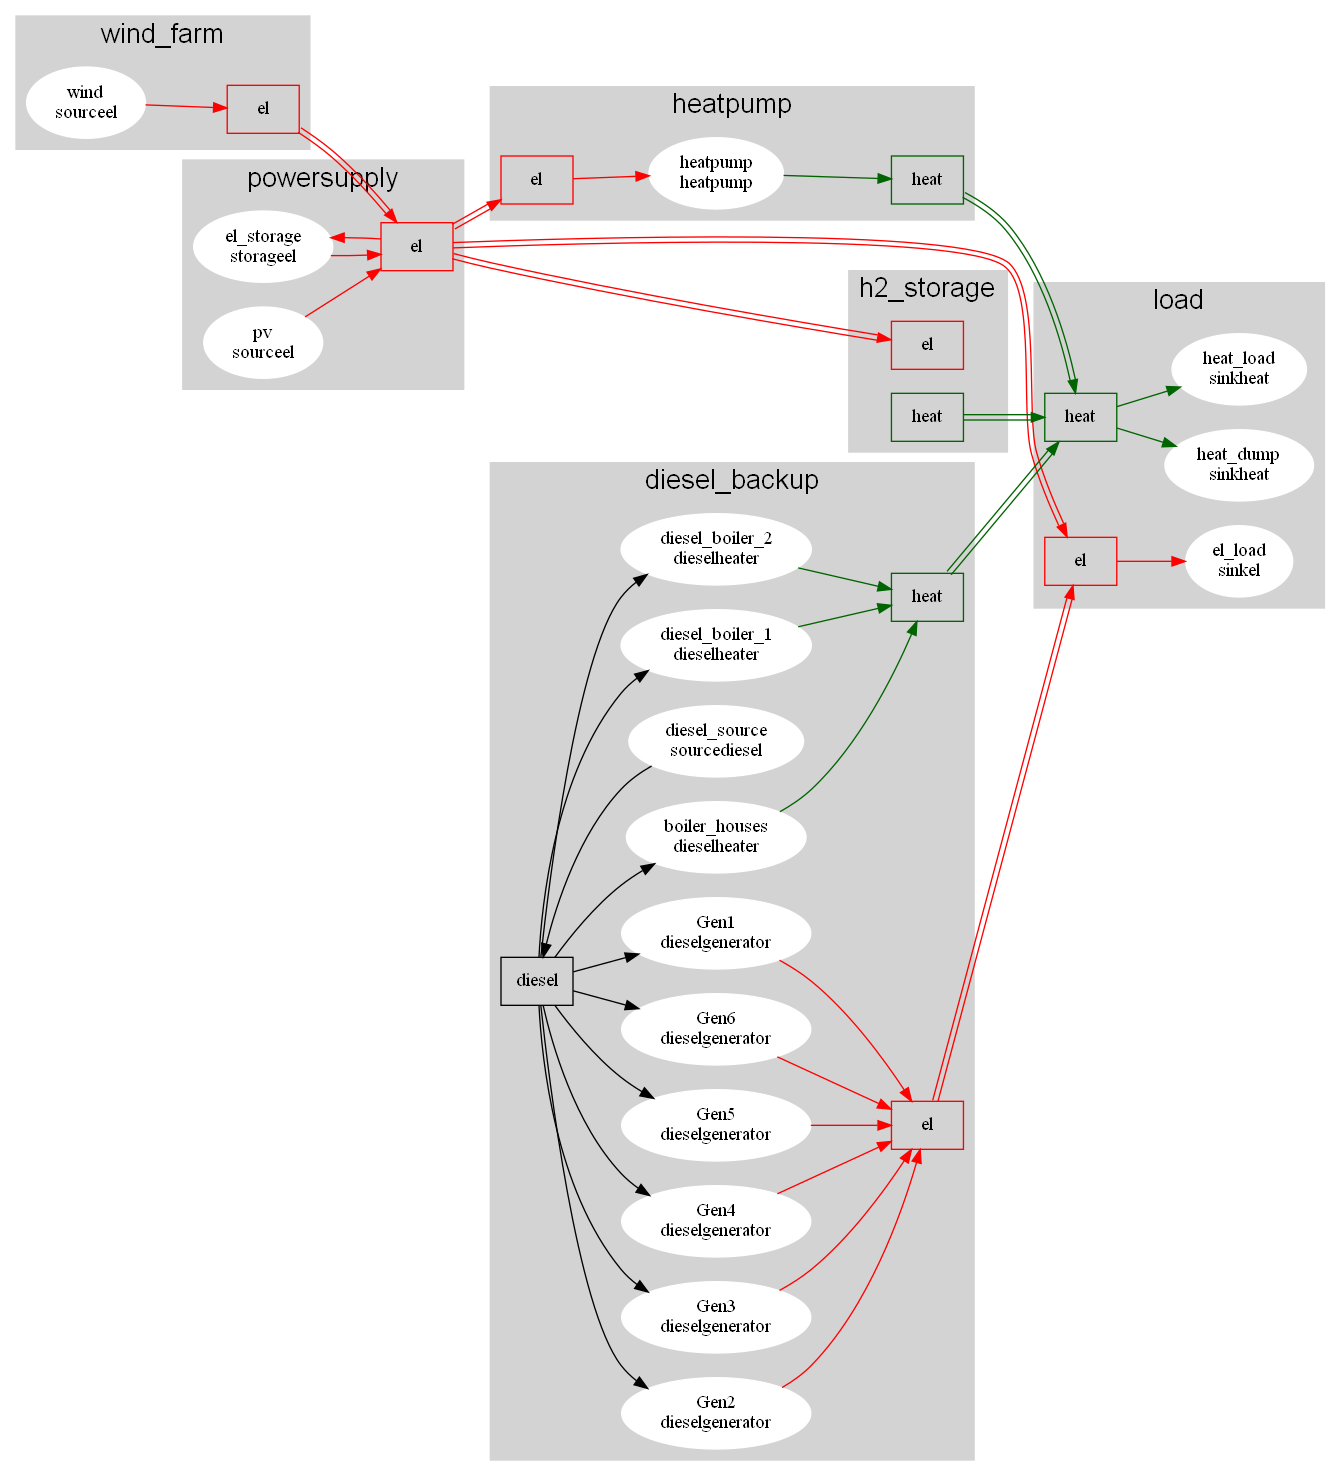

In [18]:
# View energy system
dotG=plots.plot_network(simulator,timestep=None,filename=None,rank_direction="LR",hide_edgelabel=True,only_carrier=None,fontsize=20,fontname = "helvetica",)
IPython.display.Image(dotG.create_png(prog="dot")) #scales automatically to page width
#dotG.write_pdf(path=outpath+"diagram0_{}.pdf".format(case))

### Some checks on input data

In [19]:
25.12, 25.063, 25.081

(25.12, 25.063, 25.081)

In [20]:
print(simulator.optimiser.all_edges['heat_hp_load'].edge_data)

id='heat_hp_load' node_from='heatpump' node_to='load' length_km=None flow_max=None bidirectional=True include=True carrier=<CarrierType.HEAT: 'heat'> power_loss_function=None


In [21]:
#print(simulator.optimiser.all_devices["backup_east_1"].compute_operating_costs(simulator.optimiser,[0,1]))

## Solve

If the problem is infeasible, try 
* relaxing pressure deviation limits (generic value and per-node value)
* add a high cost emergency generator (that could represent load shedding) to ensure energy balance can be satisfied
* make sure excess heat/water/gas has a place to go


In [22]:
dev_d=simulator.optimiser.all_devices["wind"].dev_data
node_d=simulator.optimiser.all_nodes["powersupply"].node_data

In [23]:
#simulator.optimiser.write("testplatform.mps")
sim_result = simulator.run_simulation(solver="gurobi",time_range=timerange,write_yaml=False,time_limit=25)
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sim_result.co2_rate.mean()))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(sim_result.co2_intensity.mean()))
#print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in sim_result.export_revenue.mean().items() if v!=0],"$/s")

100%|██████████| 7/7 [03:17<00:00, 28.27s/it]

Mean CO2 emission rate      = 0.6 kgCO2/s
Mean CO2 emission intensity = nan kgCO2/Sm3oe


In [24]:
print(sim_result.op_cost.to_string())

0      0.056964
1      0.060077
2      0.062179
3      0.071962
4      0.069098
5      0.062804
6      0.056120
7      0.064643
8      0.066542
9      0.060169
10     0.071285
11     0.059356
12     0.081160
13     0.060883
14     0.069846
15     0.075184
16     1.127528
17     1.211895
18     0.557297
19     0.218348
20     0.958634
21     0.391470
22     0.213403
23     1.228916
24     1.193854
25     0.855902
26     1.286108
27     1.302642
28     2.234117
29     2.203386
30     2.194662
31     2.212226
32     2.205148
33     2.193559
34     3.355458
35     3.598629
36     3.199286
37     3.555910
38     2.193784
39     2.184319
40     2.159801
41     2.163593
42     2.150615
43     2.142776
44     1.157515
45     1.155364
46     2.116467
47     2.535822
48     2.143405
49     2.143411
50     2.151386
51     2.140652
52     2.136817
53     2.139160
54     2.146066
55     2.158107
56     3.553493
57     3.563006
58     3.586933
59     3.380579
60     3.598058
61     3.607716
62     3

In [25]:
print(sim_result.op_cost.to_string())

0      0.056964
1      0.060077
2      0.062179
3      0.071962
4      0.069098
5      0.062804
6      0.056120
7      0.064643
8      0.066542
9      0.060169
10     0.071285
11     0.059356
12     0.081160
13     0.060883
14     0.069846
15     0.075184
16     1.127528
17     1.211895
18     0.557297
19     0.218348
20     0.958634
21     0.391470
22     0.213403
23     1.228916
24     1.193854
25     0.855902
26     1.286108
27     1.302642
28     2.234117
29     2.203386
30     2.194662
31     2.212226
32     2.205148
33     2.193559
34     3.355458
35     3.598629
36     3.199286
37     3.555910
38     2.193784
39     2.184319
40     2.159801
41     2.163593
42     2.150615
43     2.142776
44     1.157515
45     1.155364
46     2.116467
47     2.535822
48     2.143405
49     2.143411
50     2.151386
51     2.140652
52     2.136817
53     2.139160
54     2.146066
55     2.158107
56     3.553493
57     3.563006
58     3.586933
59     3.380579
60     3.598058
61     3.607716
62     3

In [26]:
print(sim_result.op_cost_per_dev.backup_east_1.to_string())

AttributeError: 'Series' object has no attribute 'backup_east_1'

In [ ]:
print(sim_result.op_cost_per_dev)

In [ ]:
sim_result.device_flow.wind.el.out[152]

In [ ]:
sim_result.device_flow.heatpump.el[152]

In [ ]:
sim_result.device_flow.diesel_source.diesel.out[152]

In [ ]:
sum(sim_result.device_flow.diesel_boiler_2.heat.out)

In [ ]:
sim_result.co2_intensity

In [ ]:
sim_result.co2_rate

In [ ]:
simulator.optimiser.optimisation_parameters.planning_horizon

In [ ]:
sum(sim_result.co2_rate*3600) #co2-emissions for the entire simulation period [kg]

In [ ]:
print(simulator.optimiser.all_devices['backup_east_1'].compute_CO2(simulator.optimiser, [1]))

In [ ]:
#simulator.optimiser.updateOptimisationModel(timestep=0,profiles=data.profiles,first=True)
simulator.optimiser.write("test.mps",io_options = {"symbolic_solver_labels":True})

In [ ]:
#simulator.optimiser.constr_injectionwell_Pmax.pprint()
#simulator.optimiser.constrO_elReserveMargin[6].pprint()
pyo.value(simulator.optimiser.varEdgeFlow["el_ps_load",10])
#simulator.optimiser.constrE_w2_flow.pprint()

In [ ]:
print(pyo.value(simulator.optimiser.paramProfiles["V105",1]),
    pyo.value(simulator.optimiser.varDeviceIsOn["wind",6]),
    pyo.value(simulator.optimiser.varDeviceIsOn["electrolyser",6]),
    pyo.value(simulator.optimiser.varDeviceIsOn["heatpump",6]),
)

## Save/Load simulation results
By saving to pickle file, it easy to later open and analyse the results without having to re-run the simulation

In [ ]:
pickle_save='{}case{}.pkl'.format(outpath,case)
# Save (pickle) - for later opening and analysis
dumpdata={"data":data,"result":sim_result}
with open(pickle_save, mode='wb') as file:
   pickle.dump(dumpdata, file)
print("Results were saved to {}".format(pickle_save))

In [ ]:
# Open previously saved object (including simulation results)
#with open(pickle_save, mode='rb') as file:
#   sim_data = cloudpickle.load(file)
#data=sim_data["data"]
#sim_result=sim_data["result"]

## Analyse results

In [ ]:
import oogeso.result_analysis
kpi = oogeso.result_analysis.compute_kpis(sim_result, sim_data=data, fuel_carrier = "diesel")#, windturbines=['wind'])
kpi = pd.DataFrame.from_dict(kpi,orient="index",columns=[case])
kpi

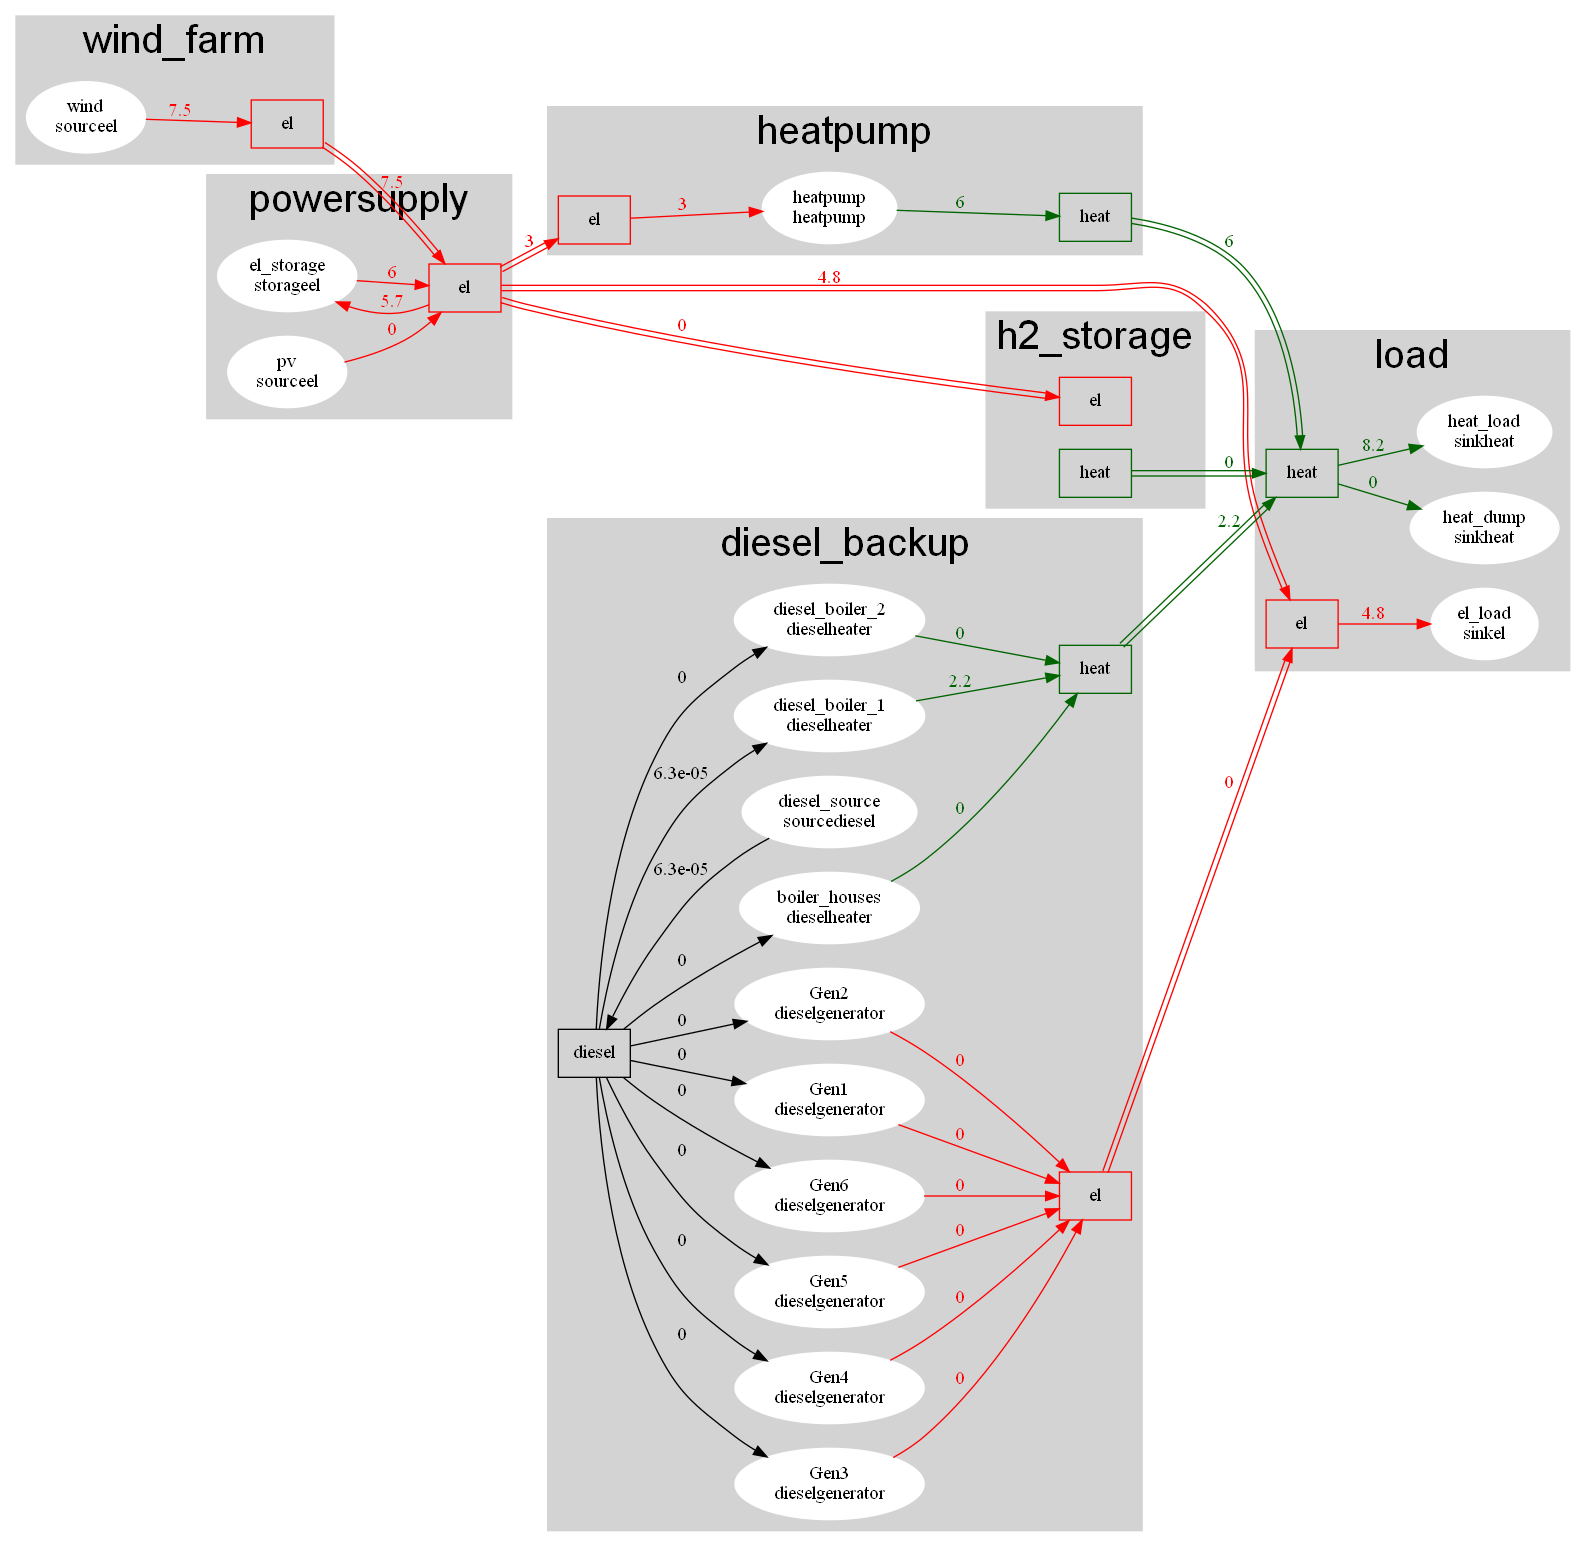

In [47]:
tstep=21
gCombined = plots.plot_network(simulator=simulator,timestep=tstep,numberformat="{:.3g}",
                              filename=None,only_carrier=None,fontsize=30,fontname = "helvetica",
                              hide_losses=True)
IPython.display.Image(gCombined.create_png())
#gCombined.write_png(path=outpath+"diagram_{}.pdf".format(case),f="pdf")
#gCombined.write_pdf(path=outpath+"diagram_{}.pdf".format(case))

In [28]:
print(sim_result.device_flow.el_load.el["in"].to_string())

time
0      4.810
1      4.330
2      4.540
3      4.690
4      4.300
5      4.480
6      4.530
7      4.540
8      4.620
9      4.680
10     4.800
11     4.870
12     4.990
13     5.060
14     5.150
15     5.170
16     5.170
17     5.050
18     4.970
19     4.940
20     4.900
21     4.830
22     4.800
23     4.690
24     4.560
25     4.530
26     4.550
27     4.490
28     4.540
29     4.610
30     4.730
31     5.170
32     5.510
33     6.200
34     6.380
35     6.320
36     6.300
37     6.330
38     6.340
39     6.440
40     6.720
41     6.640
42     6.620
43     6.470
44     5.820
45     6.340
46     6.150
47     5.700
48     5.320
49     5.230
50     5.210
51     5.220
52     5.240
53     5.290
54     5.510
55     5.950
56     6.800
57     7.010
58     7.040
59     6.934
60     6.800
61     6.950
62     6.816
63     6.554
64     6.740
65     6.600
66     6.620
67     6.730
68     6.190
69     6.420
70     6.380
71     5.650
72     5.400
73     5.310
74     5.260
75     5.240
76     

In [29]:
print(sim_result.device_flow.heat_dump.to_string())

carrier   terminal  time
diesel    in        0       0.000000e+00
                    1       0.000000e+00
                    2       0.000000e+00
                    3       0.000000e+00
                    4       0.000000e+00
                    5       0.000000e+00
                    6       0.000000e+00
                    7       0.000000e+00
                    8       0.000000e+00
                    9       0.000000e+00
                    10      0.000000e+00
                    11      0.000000e+00
                    12      0.000000e+00
                    13      0.000000e+00
                    14      0.000000e+00
                    15      0.000000e+00
                    16      0.000000e+00
                    17      0.000000e+00
                    18      0.000000e+00
                    19      0.000000e+00
                    20      0.000000e+00
                    21      0.000000e+00
                    22      0.000000e+00
                    23      0.00

In [30]:
#simulator.optimiser.all_nodes['wells'].devices_serial
#sim_result.dfEdgeFlow.unstack("edge").loc[151]
#simulator.optimiser.constrN_wells_energybalance["gas","out",0].pprint()
#print(pyo.value(simulator.optimiser.varDeviceFlow["wellL1","gas","out",0]))
#print(pyo.value(simulator.optimiser.varDeviceFlow["wellL2","gas","out",0]))
#print(pyo.value(simulator.optimiser.varEdgeFlow["cL2g",0]))
#print(pyo.value(simulator.optimiser.varEdgeLoss21["cL2g",0]))

In [31]:
plots.plotter='matplotlib'
fig2=plots.plot_sum_power_mix(sim_result,simulator.optimiser,carrier="el")#,filename=None,devs_shareload=["wind","pv"])#['Gen1','Gen2','Gen3'])
#fig2.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=0,b=0))
#fig2.write_image("{}/elpowermix_{}.png".format(outpath,case))
#fig2.set_size_inches(6,4)
plt.suptitle("")
fig2.show()
plt.savefig("result/poweroutput_{}x.pdf".format(case),dpi=300,bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [32]:
plots.plotter="plotly"
gts = [d for d,d_obj in simulator.optimiser.all_devices.items() if d_obj.dev_data.model in ["dieselgenerator","source_el"]]
fig=plots.plot_device_profile(sim_result,simulator.optimiser,devs=gts,filename=None,include_on_off=True, include_prep=False,devs_shareload=None)
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=30,b=0),template="plotly_white",
                 title="Power supply and on/off status (case: {})".format(case))
fig.show()

el          heat
device                                 
Gen1             0.000000  0.000000e+00
Gen2             0.000000  0.000000e+00
Gen3             0.000000  0.000000e+00
Gen4             0.000000  0.000000e+00
Gen5             0.000000  0.000000e+00
Gen6             0.000000  0.000000e+00
boiler_houses    0.000000  0.000000e+00
diesel_boiler_1  0.000000  0.000000e+00
diesel_boiler_2  0.000000  0.000000e+00
diesel_source    0.000000  0.000000e+00
el_load          5.533488  0.000000e+00
el_storage       2.778778  0.000000e+00
heat_dump        0.000000  1.982541e-18
heat_load        0.000000  7.894258e+00
heatpump         1.690004  0.000000e+00
pv               0.000000  0.000000e+00
wind             0.000000  0.000000e+00

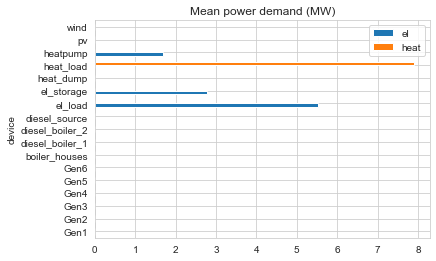

In [33]:
mean_el_demand = sim_result.device_flow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand = sim_result.device_flow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
energydemand = pd.concat({'el':mean_el_demand,'heat':mean_heat_demand},axis=1)
#energydemand.drop('heatdump',inplace=True)
energydemand.plot.barh(title="Mean power demand (MW)")
energydemand

In [34]:
energydemand.sum()

el      10.002270
heat     7.894258
dtype: float64

In [35]:
mean_flows=sim_result.device_flow.unstack(["carrier","device","terminal"]).mean().unstack(["carrier","terminal"])
print("Mean flows:\n",mean_flows.sum())
print("Mean flow per device:")
mean_flows

Mean flows:
 carrier   terminal
diesel    in           0.000242
          out          0.000242
el        in          10.002270
          out         10.002270
heat      in           7.894258
          out          7.894258
hydrogen  in           0.000000
          out          0.000000
dtype: float64
Mean flow per device:


carrier                diesel                  el                        heat  \
terminal                   in       out        in           out            in   
device                                                                          
Gen1             4.135724e-05  0.000000  0.000000  5.574788e-01  0.000000e+00   
Gen2             0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00   
Gen3             0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00   
Gen4             6.509361e-05  0.000000  0.000000  8.837455e-01  0.000000e+00   
Gen5             6.851901e-06  0.000000  0.000000  9.222033e-02  0.000000e+00   
Gen6             3.305082e-20  0.000000  0.000000  5.485030e-16  0.000000e+00   
boiler_houses    0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00   
diesel_boiler_1  1.215223e-04  0.000000  0.000000  0.000000e+00  0.000000e+00   
diesel_boiler_2  7.088814e-06  0.000000  0.000000  0.000000e+00  0.000000e+00   
diesel_source    0.000000e+00  0.000242  0.000000  0.000000e+00  0.000000e+00   
el_load          0.000000e+00  0.000000  5.533488  0.000000e+00  0.000000e+00   
el_storage       0.000000e+00  0.000000  2.778778  2.757465e+00  0.000000e+00   
heat_dump        0.000000e+00  0.000000  0.000000  0.000000e+00  1.982541e-18   
heat_load        0.000000e+00  0.000000  0.000000  0.000000e+00  7.894258e+00   
heatpump         0.000000e+00  0.000000  1.690004  0.000000e+00  0.000000e+00   
pv               0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00   
wind             0.000000e+00  0.000000  0.000000  5.711361e+00  0.000000e+00   

carrier                   hydrogen       
terminal              out       in  out  
device                                   
Gen1             0.000000      0.0  0.0  
Gen2             0.000000      0.0  0.0  
Gen3             0.000000      0.0  0.0  
Gen4             0.000000      0.0  0.0  
Gen5             0.000000      0.0  0.0  
Gen6             0.000000      0.0  0.0  
boiler_houses    0.000000      0.0  0.0  
diesel_boiler_1  4.265433      0.0  0.0  
diesel_boiler_2  0.248817      0.0  0.0  
diesel_source    0.000000      0.0  0.0  
el_load          0.000000      0.0  0.0  
el_storage       0.000000      0.0  0.0  
heat_dump        0.000000      0.0  0.0  
heat_load        0.000000      0.0  0.0  
heatpump         3.380008      0.0  0.0  
pv               0.000000      0.0  0.0  
wind             0.000000      0.0  0.0

In [36]:
plots.plotter="plotly"
gts = [d for d,d_obj in simulator.optimiser.all_devices.items() if d_obj.dev_data.model in ["sourceel"]]
fig=plots.plot_device_profile(sim_result,simulator.optimiser,devs=gts,filename=None,include_on_off=False,include_prep=False,devs_shareload=None)
#fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=30,b=0),template="plotly_white")
fig.show()
#300 dpi and 4 inch: 1200 pixels
scale=300/96 # ratio print vs screen dpi
#fig.write_image(outpath+"powersupply.pdf",width=700,height=300,scale=scale)

In [37]:
 df = sim_result.device_flow.unstack(["carrier", "terminal"])[("el", "out")].unstack("device")
 df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
           dtype='int64', name='time', length=168)

In [38]:
import plotly
fig = plotly.subplots.make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_scatter(
                x=df.index,
                y=df["wind"],
                line_shape="hv",
                name="wind",
                #line=dict(color=colour[k]),
                stackgroup="P",
                legendgroup="wind",
                row=1,
                col=1,
            )

In [39]:
dfStartopt = pd.DataFrame()
inst=simulator.optimiser
for t in inst.setHorizon: 
    dfStartopt.loc[t,'start']=inst.varDeviceStarting['wind',t].value
    dfStartopt.loc[t,'prep']=inst.varDeviceIsPrep['heatpump',t].value
    dfStartopt.loc[t,'on']=inst.varDeviceIsOn['electrolyser',t].value
    dfStartopt.loc[t,'stop']=inst.varDeviceStopping['fuelcell',t].value
dfStartopt.head()

KeyError: "Index '('electrolyser', 0)' is not valid for indexed component 'varDeviceIsOn'"

In [ ]:
fig=plots.plot_device_profile(sim_result,simulator.optimiser,devs=['wind'],filename=None,include_forecasts=True)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [ ]:
"""
df=sim_result.device_flow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
df.columns=['gas','oil']
df=df.reset_index()
df["gas"]=df["gas"]/1000 # convert to oil equivalents
df = df.melt(var_name="Product",value_name="Volume rate (Sm3oe/s)",id_vars=('time'))
px.line(df,x="time",y="Volume rate (Sm3oe/s)",color="Product",title="Oil/gas export volumes (Sm3oe/s)").show()

plots.plot_export_revenue(sim_result)
"""

In [ ]:
simulator.optimiser.setDevice.pprint()

In [ ]:
plots.plotter="plotly"
if 'el_storage' in simulator.optimiser.setDevice:
    fig=plots.plot_device_power_energy(sim_result,simulator.optimiser,'el_storage',
                                 filename=None)#outpath+"battery_opt.png")
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
#    oogeso.plots.optimization_plots.plot_device_power_last_optimisation_1(mc,device='battery', filename=None)#outpath+"lastopt_battery.png")

In [ ]:
plots.plotter="plotly"
if 'h2_storage' in simulator.optimiser.setDevice:
    fig=plots.plot_device_power_energy(sim_result,simulator.optimiser,'h2_storage',
                                 filename=None)#outpath+"battery_opt.png")
    #fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    fig.show()

In [ ]:
simulator.optimiser.all_devices["h2_storage"].dev_data.model

In [ ]:
plots.plotter="plotly"
#fig=plots.plot_co2_rate_per_dev(sim_result,simulator.optimiser,reverseLegend=True,filename=outpath+"co2rate_opt.png",devs_shareload=gts)
#fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [ ]:
fig = plots.plot_CO2_rate(sim_result)

In [ ]:
fig=plots.plot_CO2_intensity(sim_result,filename=outpath+"co2intensity_opt.png")
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [ ]:
plots.plotter="matplotlib"
fig=plots.plot_reserve(sim_result,simulator.optimiser,dynamic_margin=True,include_sum=False)
plt.legend(loc="upper left",bbox_to_anchor=(1,1),frameon=False)
#fig.set_size_inches(5.92,1.5)
plt.savefig("result/reserve_{}x.pdf".format(case),dpi=300,bbox_inches="tight")
#fig.update_layout(autosize=False,width=700,height=200,margin=dict(l=0,r=0,t=30,b=0),template="plotly_white")
#fig.update_layout(legend_traceorder="reversed")
#fig.show()
#300 dpi and 4 inch: 1200 pixels
#scale=300/96 # ratio print vs screen dpi
#fig.write_image(outpath+"reserve.pdf",width=700,height=200,scale=scale)

In [ ]:
# This plot shows per device its output (dotted line) and the available online backup, iel reserve 
# by _other_ devices (solid line). MARGIN(t) = min_devices(backup(t) - output(t))
plots.plot_el_backup(sim_result,show_margin=True,return_margin=False)

In [ ]:
fig=plots.plot_device_power_energy(sim_result,simulator.optimiser,"h2_storage")
fig.update_layout(autosize=False,width=800,height=250,margin=dict(l=0,r=0,t=30,b=0),template="plotly_white")
fig.update_yaxes(tick0=0, dtick=1,secondary_y=True,range=[0,5.5])
fig.update_yaxes(tick0=0, dtick=100e3,secondary_y=False,range=[0,550e3])
fig.show()
fig.write_image(outpath+"h2_storage_{}.pdf".format(case))

In [ ]:
simulator.optimiser.all_devices